### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [11]:
## Verify that pytorch-geometric is correctly installed
import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import numpy as np

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [12]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.to('cuda')
model = model.eval()

#google how to transfer model onto gpu
#something like model = model.to('cuda')

In [13]:
!nvidia-smi

Wed Aug 31 20:32:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   43C    P0    78W / 300W |   1351MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:43:00.0 Off |                    0 |
|  0%   

## Load structure from PDB or CIF files


In [ ]:
!wget https://files.rcsb.org/download/6VXX.pdb -P data/    # save this to the data folder in colab

Load chain from PDB file:

In [6]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Found 2 chains: ['A' 'E'] 

Loaded chain E

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


## Calculate all possible mutations in a protein

To do this, we define the 'template' sequence - the full sequence of what we want to analyze. For example, this can be the SARS-CoV-2 spike. Then, we define the 'mutating' sequence - the section of that that we want to mutate. This could be the RBD. If both are the same, we mutate and analyze the full RBD.

In [9]:
#Calculating all possible mutants in protein

#RBD:
wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
beta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
eta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460K = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSKLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSALKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460W = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSWLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCRIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433T = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCTIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N501R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCG'
N501A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTAGVGYQPYRVVVLSFELLHAPATVCG'
E471R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTRIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
S477N = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'

wt_6vxx_spike = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKGNYNYLYRKPFERDIYFPLQSYGFQPTNVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTSQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS'
wt_6vxx_ntd = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQT'

## Why am I not using the full RBD/spike/etc.? The model won't allow me - it only takes into account lengths if they match the native sequence in the pdb.


chosenseq = alpha  #The template sequence - i.e. if you want to run full spike but mutate RBD, this is full spike.
chosenseqname = 'alpha'  
choosemutseq = alpha   #The sequence you want to mutate - for example, RBD in full spike
startpoint = 0   #The AA residue (indexed at 0) that the mutated sequence starts at in template.
true_index = 333 #The true start of the sequence in the FL spike protein; for RBD this is 333, for NTD this is 14
likelihoodorlog = 'likelihood' #Use likelihood or log likelihood for analysis
multichain = False
bindingorexpression = 'binding'

seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}

for i in range(startpoint,startpoint+len(choosemutseq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [4]:
#Saving in /data folder

output_path = 'data/all_mutant_list_'+chosenseqname+'.txt'
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [14]:
mutantlistname = 'data/all_mutant_list_'+chosenseqname+'.txt'
ll_list_name = 'data/mutant_list_lls'+chosenseqname+'.csv'

!python score_log_likelihoods.py data/6M0J.pdb \
    $mutantlistname --chain E \
    --outpath $ll_list_name

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Found 2 chains: ['A' 'E'] 

Loaded chain E

Native sequence loaded from structure file:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG


Native sequence
Log likelihood: -1.20
Perplexity: 3.30

Scoring variant sequences from sequence file..

100%|███████████████████████████████████████| 3881/3881 [41:39<00:00,  1.55it/s]
Results saved to data/mutant_list_llseta.csv


## Analysis

At this point we have all mutations & the associated log-likelihood outputs from the model.

In [78]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

#Read in data as dataframe

all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)
all_mutants_N501Y_df=data=pd.read_table("data/all_mutant_list_N501Y.txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_N501Y_df.insert(1,'sequence','')
all_mutants_delta_df=pd.read_table("data/all_mutant_list_delta.txt", sep=" ", header=None)
all_mutants_delta_df.insert(1,'sequence','')

#Split dataframe into mutation & sequence

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
N501Y_df = pd.DataFrame({'mutation':all_mutants_N501Y_df[0].iloc[::2].values, 'sequence':all_mutants_N501Y_df[0].iloc[1::2].values})
delta_df = pd.DataFrame({'mutation':all_mutants_delta_df[0].iloc[::2].values, 'sequence':all_mutants_delta_df[0].iloc[1::2].values})

#Read in mutation & log likelihood

mlistll=pd.read_csv("data/mutant_list_lls.csv", sep=",", header=0)
mlistN501Yll=data=pd.read_csv("data/mutant_list_lls_N501Y.csv", sep=",", header=0)
mlistdeltall=data=pd.read_csv("data/mutant_list_lls_delta.csv", sep=",", header=0)


In [79]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
N501Y_df['log likelihood'] = mlistN501Yll['log_likelihood']
delta_df['log likelihood'] = mlistdeltall['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood'])# -np.exp(-1.1953586339950562) #Centers them around 0 = basis sequence
N501Y_df['likelihood'] = np.exp(N501Y_df['log likelihood'])# -np.exp(-1.2073875665664673)
delta_df['likelihood'] = np.exp(delta_df['log likelihood'])# -np.exp(-1.2177070379257202)

In [80]:
### See how model computes log likelihood

In [81]:
#Distance metric

N501Y_df['ll_ratio'] = (N501Y_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)
delta_df['ll_ratio'] = (delta_df['log likelihood'] - -1.2177070379257202) - (mutants_df['log likelihood'] - -1.1953586339950562)



<AxesSubplot:>

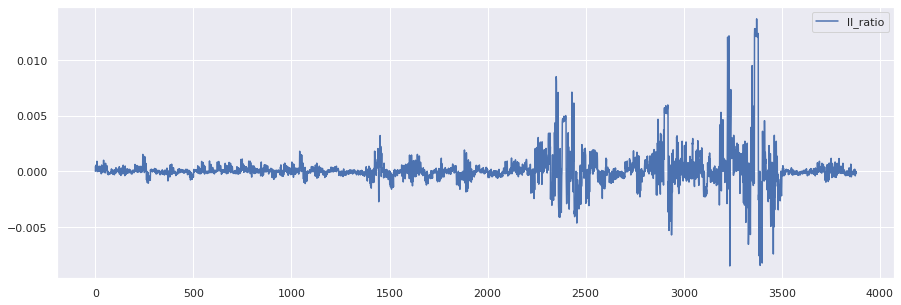

In [82]:
#Plot ratio as is

delta_df.plot(y='ll_ratio')

In [83]:
#Split > off of mutation
N501Y_df['mutation'] = N501Y_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))
delta_df['mutation'] = delta_df['mutation'].map(lambda x: x.lstrip('>'))

#Copy mutation to column index

N501Y_df['index']=N501Y_df['mutation']
mutants_df['index']=mutants_df['mutation']
delta_df['index']=delta_df['mutation']

#Remove wild type sequence (first one)

N501Y_df_noWT = N501Y_df.copy()
N501Y_df_noWT = N501Y_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

delta_df_noWT = delta_df.copy()
delta_df_noWT = delta_df_noWT.iloc[1: , :]

#Remove index from mutation column, and amino acid from index column.
#This gives us one column defining index & one column defining the amino acid at that position.

N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')

delta_df_noWT['mutation'] = delta_df_noWT['mutation'].str.replace('\d+', '')
delta_df_noWT['index'] = delta_df_noWT['index'].str.replace(str(aalist), '')

/tmp/ipykernel_900134/100052836.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['mutation'] = N501Y_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_900134/100052836.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  N501Y_df_noWT['index'] = N501Y_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_900134/100052836.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_900134/100052836.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_900134/100052836.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  delta_df_

In [84]:
#Shift index to true index; i.e. change position 0 to position 333 for RBD.

true_index = 333

N501Y_df_noWT['index'] = pd.to_numeric(N501Y_df_noWT['index'])
N501Y_df_noWT['index'] = N501Y_df_noWT['index'] + true_index

delta_df_noWT['index'] = pd.to_numeric(delta_df_noWT['index'])
delta_df_noWT['index'] = delta_df_noWT['index'] + true_index

#result here is a pivot table of ll_ratio, other pivot tables are of just likelihood

result = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + true_index

#Create a pivot table w/ index on x and mutation on y

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_N501Y = N501Y_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

result_delta = delta_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

result_delta_only = delta_df_noWT.pivot_table(index='mutation', columns='index', values='likelihood',sort=False)

In [85]:
#Normalize columns to 1

#for column in result_N501Y:
#    result_N501Y[column] = result_N501Y[column]/result_N501Y[column].sum()

#for column in result_mut:
#    result_mut[column] = result_mut[column]/result_mut[column].sum()


In [86]:
#Ship to excel

result_delta.to_excel('data/result_delta.xlsx')

# Comparing Alpha (N501Y) and Wuhan

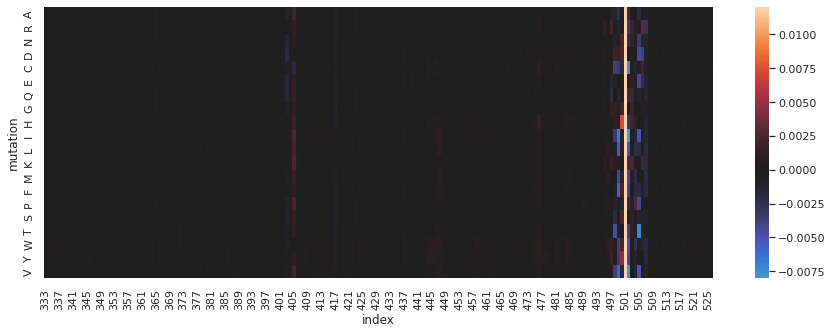

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#Heatmap of ll_ratio

In [88]:
#### NA THE 501 POSITION ABOVE

### Ian Wilson group Nat Comm Flu epistasis deep mutational scanning 2020 7 diff flu-HA backgrounds all possible amino acid changes at like 6 sites

### make sure i'm using gpu compute lmao

### Figure out if JSD is using softmax to make it probabilities -> making it jensen shannon

<AxesSubplot:xlabel='index'>

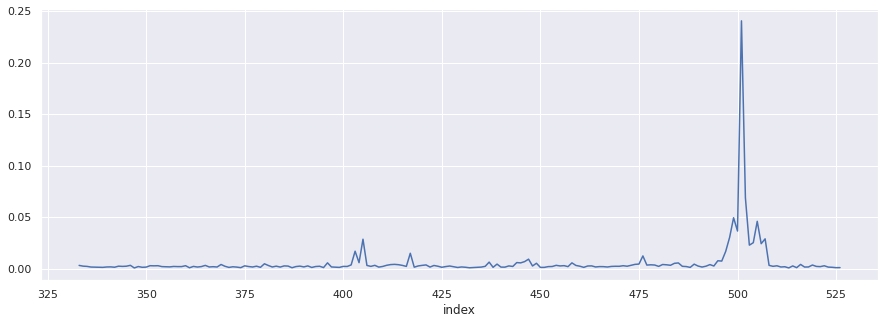

In [89]:
#Quick & dirty quantification - vertical sum of absolute values of heatmap

result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

# Wuhan/Variants Heatmaps

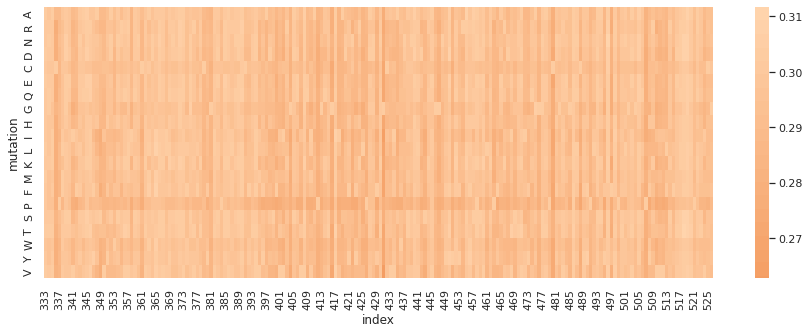

In [90]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='icefire',center=0)
plt.show()
#Wuhan

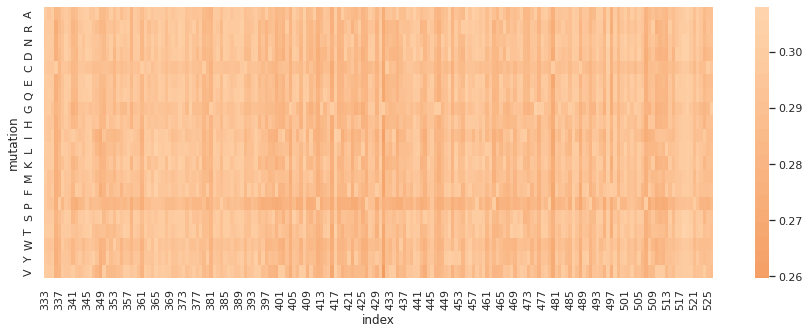

In [91]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_N501Y, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

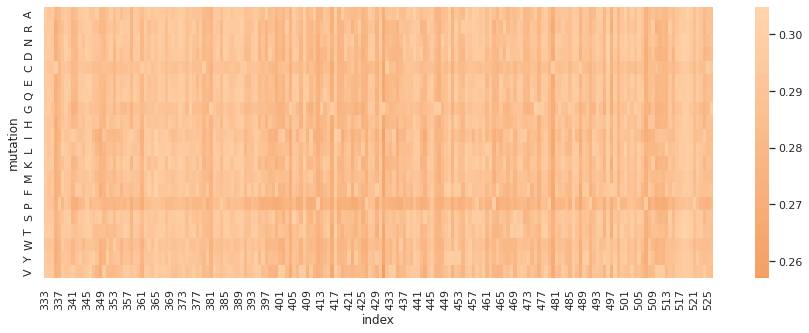

In [92]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_delta_only, annot=False, cmap='icefire',center=0)
plt.show()
#Delta

# Bloom Data

In [93]:
#Let's try a Spearman correlation with the JB expression data.

#First, let's import the data and separate it into dataframes for each variant.

jb_df = pd.read_csv('data/bloom_science_expr.csv')

In [94]:
#create unique list of names
VariantNames = jb_df.target.unique()

#create a data frame dictionary to store the data frames
bloom_data = {elem : pd.DataFrame() for elem in VariantNames}

for key in bloom_data.keys():
    bloom_data[key] = jb_df[:][jb_df.target == key]

In [95]:
#Pivot table to get each variant
bloom_N501Y = bloom_data['N501Y'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_wuhan = bloom_data['Wuhan-Hu-1'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)
bloom_delta = bloom_data['Delta'].pivot_table(index='mutant', columns='position', values='delta_expr',sort=False)

#Drop the first two columns and last five columns; these are cut out in the native sequence for esm-if1.
bloom_N501Y = bloom_N501Y.iloc[: , 2:196]
bloom_wuhan = bloom_wuhan.iloc[: , 2:196]
bloom_delta = bloom_delta.iloc[: , 2:196]


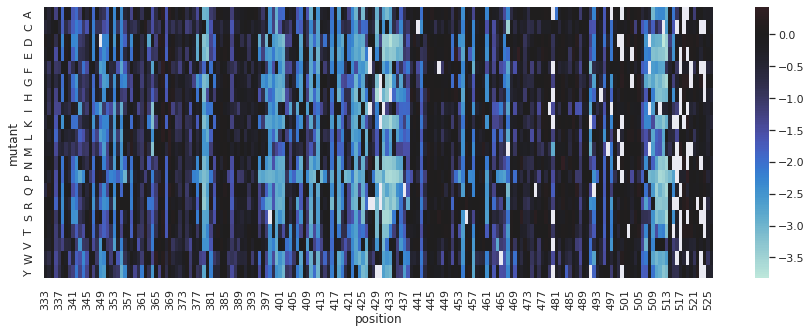

In [96]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_wuhan, annot=False, cmap='icefire',center=0)
plt.show()
#wuhan

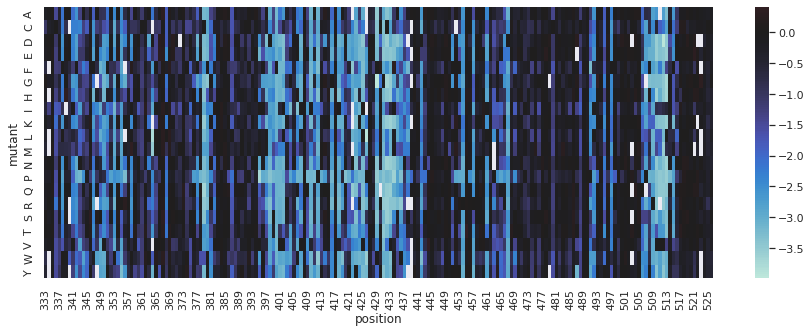

In [97]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(bloom_N501Y, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

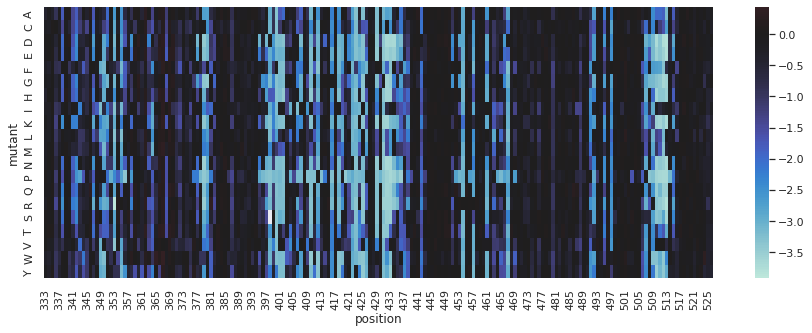

In [98]:
sns.set(rc = {'figure.figsize':(15,5)})

cmaptest = sns.diverging_palette(240, 0, s=100, sep=1 ,l=70, center='dark',as_cmap=True)

sns.heatmap(bloom_delta, annot=False, cmap='icefire',center=0)
plt.show()
#delta

In [99]:
#Now to actually try a spearman correlation; we need to put all the bloom delta expression and my data in one column each.

N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})

N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data['N501Y'],on = ['position', 'mutant'], how = 'left')

In [100]:
#All the same data processing for delta

delta_df_noWT_rn = delta_df_noWT.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
delta_merged_df = delta_df_noWT_rn.merge(bloom_data['Delta'],on = ['position', 'mutant'], how = 'left')


In [101]:
#Now the actual spearman correlation


corr_columns_N501Y = N501Y_merged_df[['likelihood','delta_expr']]

corr_columns_delta = delta_merged_df[['likelihood','expr']]


N501Y expression correlation

In [102]:
corr_columns_N501Y.corr(method='spearman')

,likelihood,delta_expr
likelihood,1.000000,0.693525
delta_expr,0.693525,1.000000


<AxesSubplot:xlabel='likelihood'>

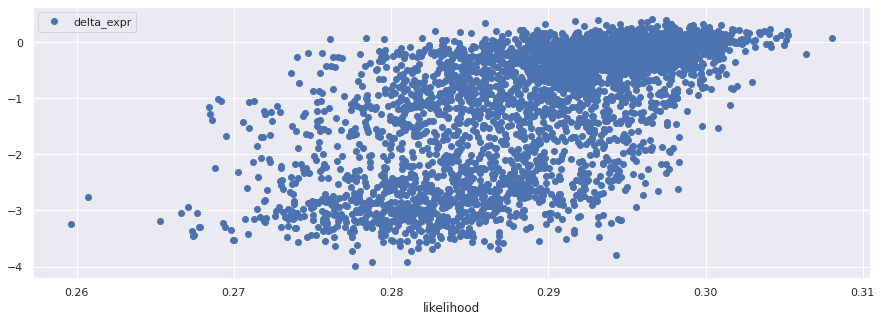

In [103]:
corr_columns_N501Y.plot(x='likelihood',y='delta_expr',style='o')

Delta expression correlation

In [104]:
corr_columns_delta.corr(method='spearman')

,likelihood,expr
likelihood,1.00000,0.65381
expr,0.65381,1.00000


<AxesSubplot:xlabel='likelihood'>

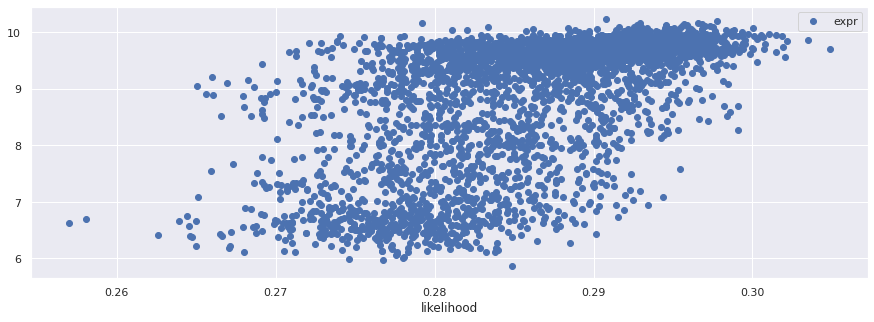

In [105]:
corr_columns_delta.plot(x='likelihood',y='expr',style='o')

Correlation for binding

In [106]:
corr_columns_N501Y_bind = N501Y_merged_df[['likelihood','bind']]
corr_columns_N501Y_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.640286
bind,0.640286,1.000000


In [107]:
corr_columns_delta_bind = delta_merged_df[['likelihood','bind']]
corr_columns_delta_bind.corr(method='spearman')

,likelihood,bind
likelihood,1.000000,0.621878
bind,0.621878,1.000000


In [108]:
#Put bloom data as expr_ratio on same metric that we did for ESM outputs

bloom_data_N501Y_expr = bloom_data['N501Y'][['position','mutant','expr']]
bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


/tmp/ipykernel_900134/1383603678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_N501Y_expr['expr_ratio'] = np.log(bloom_data['N501Y']['expr'].to_numpy()/10.14430) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


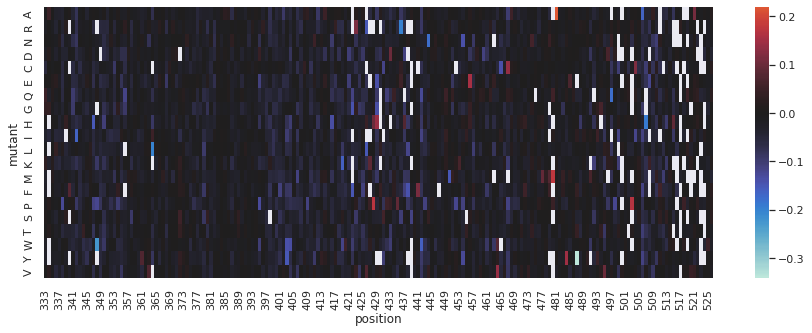

In [109]:
#Actual comparison for N501Y with same metric

N501Y_merged_df_2 = N501Y_df_noWT_rn.merge(bloom_data_N501Y_expr,on = ['position', 'mutant'], how = 'left')


bloom_pivot_N501Y = N501Y_merged_df_2.pivot_table(index='mutant', columns='position', values='expr_ratio',sort=False)

sns.heatmap(bloom_pivot_N501Y, annot=False, cmap='icefire',center=0)
plt.show()


<AxesSubplot:xlabel='position'>

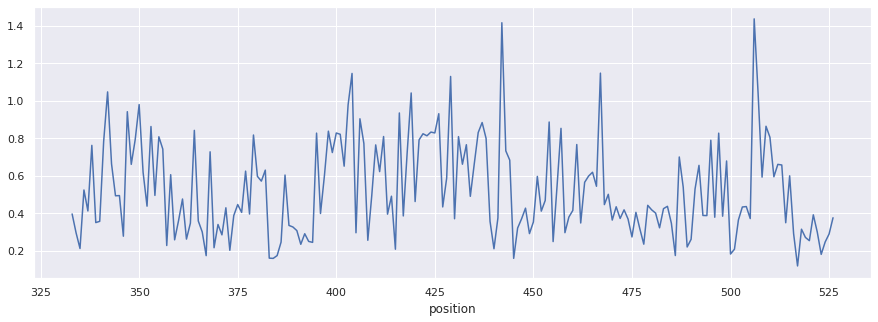

In [110]:
#Vertical sum for bloom data N501Y comparison
bloom_pivot_N501Y_abs = abs(bloom_pivot_N501Y)
bloom_pivot_N501Y_sum = bloom_pivot_N501Y_abs.sum()
bloom_pivot_N501Y_sum.plot()

In [111]:
N501Y_df_noWT_rn = N501Y_df_noWT.copy()
N501Y_df_noWT_rn = N501Y_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
N501Y_merged_df = N501Y_df_noWT_rn.merge(bloom_data_N501Y_expr,on = ['position', 'mutant'], how = 'left')

Correlating the epistatic shifts w/ both operated on the same way.

In [112]:
corr_columns_N501Y_expr_ratio = N501Y_merged_df[['ll_ratio','expr_ratio']]
corr_columns_N501Y_expr_ratio.corr(method='spearman')

,ll_ratio,expr_ratio
ll_ratio,1.000000,0.008528
expr_ratio,0.008528,1.000000


<AxesSubplot:xlabel='ll_ratio'>

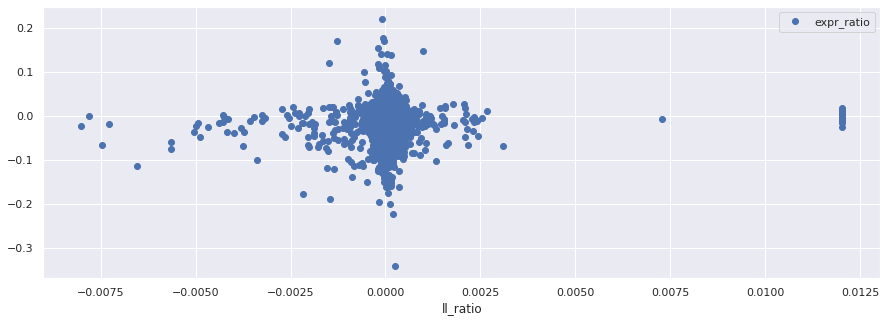

In [113]:
corr_columns_N501Y_expr_ratio.plot(x='ll_ratio',y='expr_ratio',style='o')

In [114]:
#Going through the same process for Delta

bloom_data_Delta_expr = bloom_data['Delta'][['position','mutant','expr']]
bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)

delta_df_noWT_rn = delta_df_noWT_rn.copy()
delta_df_noWT_rn = delta_df_noWT_rn.rename(columns={"index":"position","mutation":"mutant"})
Delta_merged_df = delta_df_noWT_rn.merge(bloom_data_Delta_expr,on = ['position', 'mutant'], how = 'left')

corr_columns_Delta_expr_ratio = Delta_merged_df[['ll_ratio','expr_ratio']]
corr_columns_Delta_expr_ratio.corr(method='spearman')

/tmp/ipykernel_900134/3595949502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bloom_data_Delta_expr['expr_ratio'] = np.log(bloom_data['Delta']['expr'].to_numpy()/9.79026) - np.log(bloom_data['Wuhan-Hu-1']['expr'].to_numpy()/10.18588)


,ll_ratio,expr_ratio
ll_ratio,1.000000,0.041724
expr_ratio,0.041724,1.000000


Jensen-shannon divergence

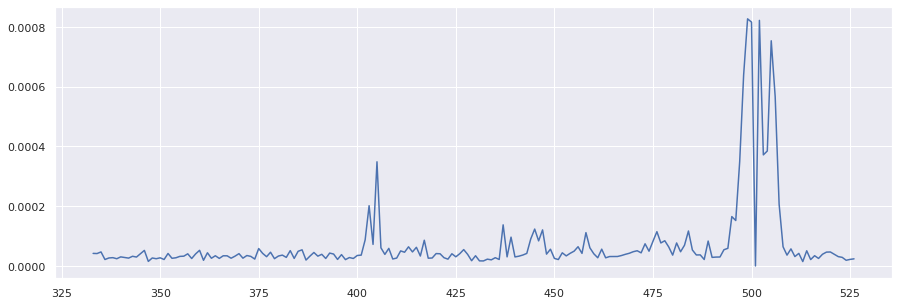

In [115]:
#Cycle through all positions, calculate JSD between results_N501Y and result_mutant at each position
import scipy

jsd_N501Y = []
columns=[]

for column in result_N501Y:
    columns.append(column)
    jsd_N501Y.append(scipy.spatial.distance.jensenshannon(result_N501Y[column],result_mut[column]))
    
plt.plot(columns,jsd_N501Y)

In [116]:
result_N501Y

index,333,334,335,336,337,338,339,340,341,342,...,517,518,519,520,521,522,523,524,525,526
mutation,,,,,,,,,,,,,,,,,,,,,
A,0.299415,0.295765,0.298789,0.284023,0.285048,0.294199,0.298014,0.294803,0.284047,0.288472,...,0.296232,0.299183,0.304811,0.298977,0.288998,0.298977,0.294112,0.286218,0.290174,0.290596
R,0.298242,0.297796,0.298329,0.274237,0.285396,0.289461,0.296921,0.295559,0.280907,0.285298,...,0.299099,0.299685,0.300897,0.297801,0.288706,0.299105,0.294789,0.283598,0.291835,0.290579
N,0.297412,0.298977,0.296878,0.276017,0.288552,0.293351,0.300760,0.295027,0.283901,0.285075,...,0.299314,0.303422,0.304008,0.297963,0.289917,0.298409,0.293701,0.285396,0.288778,0.293268
D,0.298956,0.297317,0.296242,0.275268,0.285905,0.292264,0.300945,0.297167,0.284868,0.282947,...,0.298986,0.304138,0.304106,0.297384,0.289495,0.297019,0.292356,0.280313,0.286050,0.288356
C,0.297787,0.293796,0.295066,0.298977,0.281667,0.293908,0.294950,0.290510,0.283697,0.284442,...,0.294446,0.297445,0.297699,0.293296,0.284963,0.293867,0.288507,0.287479,0.298977,0.293766
E,0.299866,0.298190,0.298076,0.274503,0.283776,0.292459,0.299325,0.298977,0.285077,0.285264,...,0.297834,0.300542,0.302610,0.299163,0.289775,0.298153,0.293432,0.283284,0.287449,0.288619
Q,0.297893,0.298852,0.297688,0.274562,0.285355,0.293264,0.298424,0.297297,0.283823,0.283854,...,0.298443,0.299342,0.302329,0.298940,0.289602,0.298969,0.294148,0.286258,0.289708,0.290851
G,0.298364,0.298798,0.292338,0.280217,0.284493,0.292067,0.298977,0.289668,0.275768,0.281424,...,0.291664,0.298358,0.300898,0.294894,0.286546,0.289417,0.285985,0.280390,0.285950,0.298977
H,0.296875,0.295481,0.295249,0.274425,0.284582,0.292336,0.296270,0.291584,0.282598,0.285667,...,0.297996,0.300575,0.298977,0.296590,0.288223,0.294874,0.289118,0.281331,0.289338,0.289883


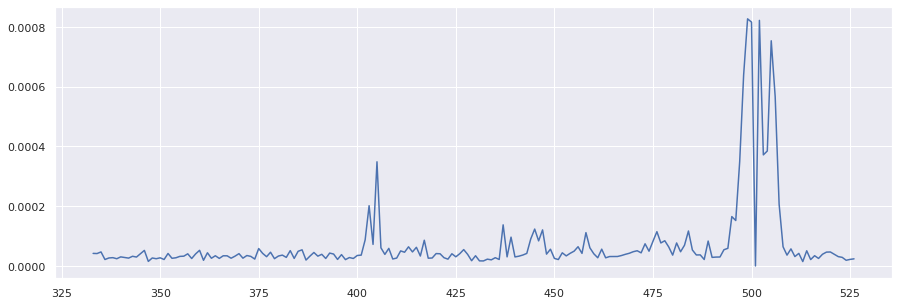

In [117]:
plt.plot(columns,jsd_N501Y)

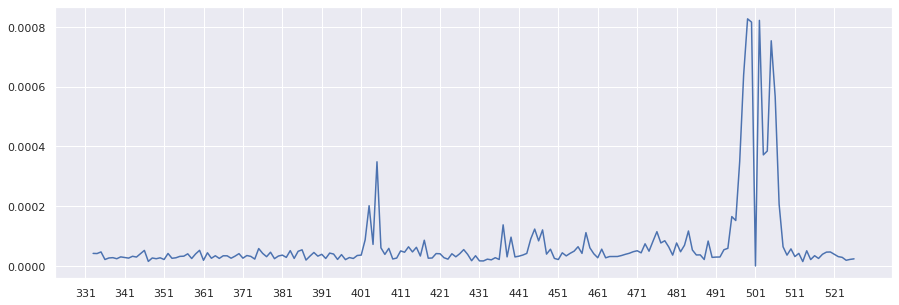

In [118]:
#Cycle through all positions, calculate JSD between results_N501Y and result_mutant at each position

#This time did absolute values of each vector.

#You want JSD between pairs of columns.

import scipy

jsd_N501Y = []
columns = []

for column in result_N501Y:
    columns.append(column)
    jsd_N501Y.append(scipy.spatial.distance.jensenshannon(result_N501Y[column],result_mut[column]))
    
plt.plot(columns,scipy.spatial.distance.jensenshannon(abs(result_N501Y),abs(result_mut),axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()

In [119]:
bloom_data['N501Y']

,target,wildtype,position,mutant,mutation,bind,delta_bind,n_bc_bind,n_libs_bind,bind_rep1,bind_rep2,bind_rep3,expr,delta_expr,n_bc_expr,n_libs_expr,expr_rep1,expr_rep2
8040,N501Y,N,331,A,N331A,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
8041,N501Y,N,331,C,N331C,9.59284,-0.36219,13,3,9.63199,9.57676,9.56977,9.58908,-0.55522,9,2,9.66335,9.51482
8042,N501Y,N,331,D,N331D,9.86832,-0.08671,10,3,9.77909,9.78857,10.03729,10.07589,-0.06841,8,2,9.91359,10.23819
8043,N501Y,N,331,E,N331E,9.92660,-0.02208,1,1,NaN,9.92660,NaN,10.13296,-0.01134,2,2,10.32345,9.94246
8044,N501Y,N,331,F,N331F,9.58949,-0.36872,4,2,9.50579,NaN,9.67318,9.52710,-0.58089,2,1,9.52710,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,N501Y,T,531,S,T531S,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
12056,N501Y,T,531,T,T531T,9.95503,0.00000,23788,3,9.88468,9.94868,10.03172,10.14430,0.00000,21054,2,10.10799,10.18061
12057,N501Y,T,531,V,T531V,10.56670,0.53498,1,1,NaN,NaN,10.56670,10.20020,0.09221,1,1,10.20020,NaN
12058,N501Y,T,531,W,T531W,9.92021,-0.02847,1,1,NaN,9.92021,NaN,10.16400,-0.01662,1,1,NaN,10.16400


In [120]:
#Importing binding and expression JSD from Bloom data as dataframes

binding_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_by_target.csv'
expression_jsd_url = 'https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/main/results/epistatic_shifts/JSD_versus_Wuhan1_EXPRESSION_by_target.csv'

if bindingorexpression == 'binding':
    metric_jsd_df = pd.read_csv(binding_jsd_url)
else:
    metric_jsd_df = pd.read_csv(expression_jsd_url)



#binding_jsd_df = pd.read_csv(binding_jsd_url)
#metric_jsd_df = pd.read_csv(binding_jsd_url)   #CHANGED TO BINDING!!! CHANGE BACK!!!



In [121]:
#Selecting just N501Y binding + those that bind > 1 stdev above mean (top ~7%)

binding_jsd_df_N501Y = binding_jsd_df.loc[(binding_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (binding_jsd_df['bg_2'] == 'N501Y')]
mean_N501Y = binding_jsd_df_N501Y['JSD'].mean()
sd_N501Y = binding_jsd_df_N501Y['JSD'].std()


top_N501Y_bind_df = binding_jsd_df_N501Y[((binding_jsd_df_N501Y['JSD'] > mean_N501Y+sd_N501Y))]

top_N501Y_bind_df

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
273,Wuhan-Hu-1,N501Y,403,0.274384,0.268364,0.264177
276,Wuhan-Hu-1,N501Y,406,0.090418,0.077987,0.077987
316,Wuhan-Hu-1,N501Y,446,0.091769,0.098343,0.098343
317,Wuhan-Hu-1,N501Y,447,0.137535,0.114352,0.114352
319,Wuhan-Hu-1,N501Y,449,0.281511,0.281511,0.281511
361,Wuhan-Hu-1,N501Y,491,0.086264,0.086320,0.089019
364,Wuhan-Hu-1,N501Y,494,0.165004,0.165004,0.173983
365,Wuhan-Hu-1,N501Y,495,0.144450,0.131841,0.127673
366,Wuhan-Hu-1,N501Y,496,0.140887,0.140887,0.140887
368,Wuhan-Hu-1,N501Y,498,0.480134,0.480134,0.482904


In [122]:
#Selecting just N501Y expression + those that express > 1 stdev above mean (top ~12%)

expression_jsd_df_N501Y = expression_jsd_df.loc[(expression_jsd_df['bg_1'] == 'Wuhan-Hu-1') & (expression_jsd_df['bg_2'] == 'N501Y')]
mean_N501Y_exp = expression_jsd_df_N501Y['JSD'].mean()
sd_N501Y_exp = expression_jsd_df_N501Y['JSD'].std()


top_N501Y_expr_df = expression_jsd_df_N501Y[((expression_jsd_df_N501Y['JSD'] > mean_N501Y_exp+sd_N501Y_exp))]

top_N501Y_expr_df

,bg_1,bg_2,site,JSD,JSD_min3bc,JSD_min5bc
273,Wuhan-Hu-1,N501Y,403,0.274384,0.268364,0.264177
276,Wuhan-Hu-1,N501Y,406,0.090418,0.077987,0.077987
316,Wuhan-Hu-1,N501Y,446,0.091769,0.098343,0.098343
317,Wuhan-Hu-1,N501Y,447,0.137535,0.114352,0.114352
319,Wuhan-Hu-1,N501Y,449,0.281511,0.281511,0.281511
361,Wuhan-Hu-1,N501Y,491,0.086264,0.086320,0.089019
364,Wuhan-Hu-1,N501Y,494,0.165004,0.165004,0.173983
365,Wuhan-Hu-1,N501Y,495,0.144450,0.131841,0.127673
366,Wuhan-Hu-1,N501Y,496,0.140887,0.140887,0.140887
368,Wuhan-Hu-1,N501Y,498,0.480134,0.480134,0.482904


In [123]:
#Repeat for the calculated absolute value JSDs from LM data

jsd_abs = scipy.spatial.distance.jensenshannon(abs(result_N501Y),abs(result_mut))
jsd_notabs = scipy.spatial.distance.jensenshannon(result_N501Y,result_mut)
jsd_notabs_df = pd.DataFrame(jsd_notabs)
jsd_notabs_df['Index']=columns

jsd_abs_df = pd.DataFrame(jsd_abs)
jsd_abs_df['Index']=columns

mean_jsd_abs = jsd_abs_df[0].mean()
sd_jsd_abs = jsd_abs_df[0].std()

top_abs_jsd_df = jsd_abs_df[((jsd_abs_df[0] > mean_jsd_abs+sd_jsd_abs))]

top_abs_jsd_df

,0,Index
72,0.000349,405
164,0.000349,497
165,0.000639,498
166,0.000827,499
167,0.000816,500
169,0.000822,502
170,0.000372,503
171,0.000385,504
172,0.000754,505
173,0.000567,506


In [124]:
#Counting matches between expression & log likelihoods

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_N501Y_expr_df['site'])):
        count +=1
    #elif (i+1 in set(top_N501Y_expr_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_N501Y_expr_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_N501Y_expr_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

number of matches:
3
fraction of top sites found:
0.23076923076923078
fraction of predicted sites that are top sites:
0.2727272727272727


In [125]:
#Counting matches between binding & log likelihood jsd

count = 0

for i in top_abs_jsd_df['Index']:
    if (i in set(top_N501Y_bind_df['site'])):
        count +=1
    #elif (i+1 in set(top_N501Y_bind_df['site'])):
     #   count +=1
    #elif (i-1 in set(top_N501Y_bind_df['site'])):
     #   count +=1

print('number of matches:')
print(count)
print('fraction of top sites found:')
print(count/len(top_N501Y_bind_df))
print('fraction of predicted sites that are top sites:')
print(count/len(top_abs_jsd_df))

number of matches:
3
fraction of top sites found:
0.23076923076923078
fraction of predicted sites that are top sites:
0.2727272727272727


Now to do Spearman's rank correlation between JSD from language model (jsd_notabs_df) and JSD from Bloom data (expression_jsf_df_N501Y

In [126]:
#Just simplify the expression dataframe to what i need here
jsd_N501Y = expression_jsd_df_N501Y[['site','JSD']].copy()


In [127]:
#rename
jsd_notabs_df.columns = {'site' if x=='Index' else x for x in jsd_notabs_df.columns}

In [128]:
#renaming columns & merging dfs to one dataframe with site, LM jsd, and Bloom jsd
combined_jsd_df = pd.merge(jsd_notabs_df, jsd_N501Y, on='site')
combined_jsd_df.columns = {'JSD_LM' if x==0 else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'JSD_N501Y' if x=='site' else x for x in combined_jsd_df.columns}
combined_jsd_df.columns = {'Index' if x=='JSD_LM' else x for x in combined_jsd_df.columns}


In [129]:
combined_jsd_df

,JSD,JSD_N501Y,Index
0,0.000042,333,0.023594
1,0.000041,334,0.010417
2,0.000047,335,0.003853
3,0.000022,336,0.008512
4,0.000027,337,0.005127
...,...,...,...
189,0.000031,522,0.020380
190,0.000029,523,0.027438
191,0.000019,524,0.015251
192,0.000022,525,0.002626


In [138]:
def normalize(df):
    result = df.copy()
    
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

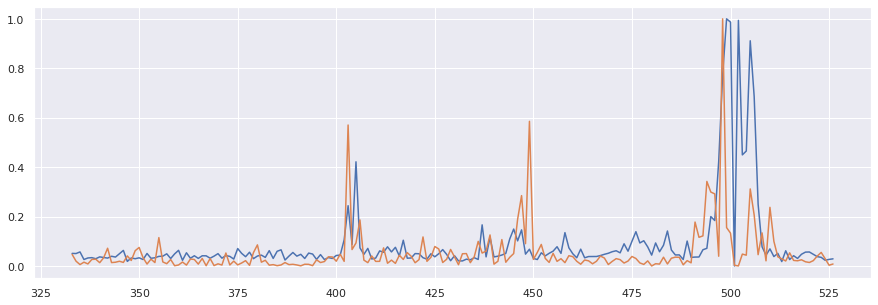

In [142]:
#Overlay the predicted and experimental JSD plots:

#plt.plot(combined_jsd_df['JSD_N501Y'], ((combined_jsd_df['JSD']-combined_jsd_df['JSD'].mean())/combined_jsd_df['JSD'].std()), label='line 1')
#plt.plot(combined_jsd_df['JSD_N501Y'], ((combined_jsd_df['Index']-combined_jsd_df['Index'].mean())/combined_jsd_df['Index'].std()), label='line 2')

plt.plot(combined_jsd_df['JSD_N501Y'], normalize(combined_jsd_df['JSD']), label='line 1')
plt.plot(combined_jsd_df['JSD_N501Y'], normalize(combined_jsd_df['Index']), label='line 2')




In [130]:
#spearman correlation pt1
combined_jsd_df.corr(method='spearman')

scipy.stats.spearmanr(combined_jsd_df['JSD'],combined_jsd_df['Index'])

SpearmanrResult(correlation=0.11427566503913274, pvalue=0.11260518106771347)

<AxesSubplot:>

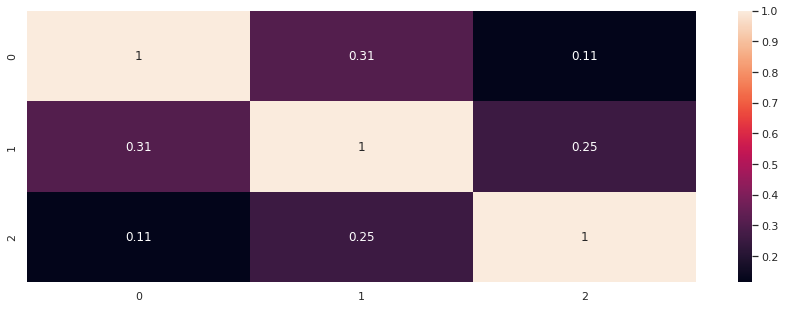

In [131]:
#spearman correlation attempt 2
corr_jsd,pval_corr_jsd = scipy.stats.spearmanr(jsd_notabs_df,jsd_N501Y[2:196]['JSD'])
sns.heatmap(corr_jsd, annot = True)


In [132]:
#Manually doing Spearman correlation to check lol

combined_jsd_df_ranks = combined_jsd_df.rank()
combined_jsd_df['JSD_rank'] = combined_jsd_df_ranks['JSD']
combined_jsd_df['JSD_N501Y_rank'] = combined_jsd_df_ranks['Index']
combined_jsd_df['d'] = combined_jsd_df['JSD_rank']-combined_jsd_df['JSD_N501Y_rank']
combined_jsd_df['d^2'] = combined_jsd_df['d']**2

rho = 1 - (6*(combined_jsd_df['d^2'].sum())/(len(combined_jsd_df)*(((len(combined_jsd_df))**2)-1)))
print(rho)
combined_jsd_df

0.11427602897609845


,JSD,JSD_N501Y,Index,JSD_rank,JSD_N501Y_rank,d,d^2
0,0.000042,333,0.023594,117.0,144.0,-27.0,729.0
1,0.000041,334,0.010417,114.0,80.0,34.0,1156.0
2,0.000047,335,0.003853,132.0,24.0,108.0,11664.0
3,0.000022,336,0.008512,15.0,64.0,-49.0,2401.0
4,0.000027,337,0.005127,44.0,37.0,7.0,49.0
...,...,...,...,...,...,...,...
189,0.000031,522,0.020380,65.0,136.0,-71.0,5041.0
190,0.000029,523,0.027438,56.0,156.0,-100.0,10000.0
191,0.000019,524,0.015251,8.0,111.0,-103.0,10609.0
192,0.000022,525,0.002626,19.0,11.0,8.0,64.0


In [133]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(combined_jsd_df)

           JSD  JSD_N501Y  Index  JSD_rank  JSD_N501Y_rank      d       d^2
0    4.198e-05        333  0.024     117.0           144.0  -27.0    729.00
1    4.150e-05        334  0.010     114.0            80.0   34.0   1156.00
2    4.692e-05        335  0.004     132.0            24.0  108.0  11664.00
3    2.156e-05        336  0.009      15.0            64.0  -49.0   2401.00
4    2.671e-05        337  0.005      44.0            37.0    7.0     49.00
5    2.773e-05        338  0.014      51.0           104.0  -53.0   2809.00
6    2.415e-05        339  0.014      25.0           107.0  -82.0   6724.00
7    3.033e-05        340  0.008      61.0            50.0   11.0    121.00
8    2.828e-05        341  0.017      53.0           120.0  -67.0   4489.00
9    2.623e-05        342  0.036      40.0           163.0 -123.0  15129.00
10   3.238e-05        343  0.008      72.0            54.0   18.0    324.00
11   2.975e-05        344  0.008      58.0            62.0   -4.0     16.00
12   4.090e-

In [134]:
jsd_N501Y

,site,JSD
201,331,0.061469
202,332,0.007132
203,333,0.023594
204,334,0.010417
205,335,0.003853
...,...,...
397,527,0.005388
398,528,0.004522
399,529,0.009693
400,530,0.018125


In [135]:
jsd_df = pd.Series(data=jsd_N501Y['JSD'],index=jsd_N501Y['site'])
print(jsd_df)
result_N501Y.max()[jsd_df.nlargest(10).index]


site
331    0.010284
332    0.004576
333    0.012742
334    0.011142
335    0.005332
         ...   
527         NaN
528         NaN
529         NaN
530         NaN
531         NaN
Name: JSD, Length: 201, dtype: float64


site
368    0.298977
364    0.299513
375    0.302936
365    0.305129
366    0.301443
380    0.298977
376    0.298977
361    0.298977
369    0.300670
401    0.298977
dtype: float64